# Customizing what happens in `fit()`

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/15<br>
**Last modified:** 2020/04/15<br>
**Description:** Complete guide to overriding the training step of the Model class.

## Introduction

When you're doing supervised learning, you can use `fit()` and everything works
smoothly.

When you need to write your own training loop from scratch, you can use the
`GradientTape` and take control of every little detail.

But what if you need a custom training algorithm, but you still want to benefit from
the convenient features of `fit()`, such as callbacks, built-in distribution support,
or step fusing?

A core principle of Keras is **progressive disclosure of complexity**. You should
always be able to get into lower-level workflows in a gradual way. You shouldn't fall
off a cliff if the high-level functionality doesn't exactly match your use case. You
should be able to gain more control over the small details while retaining a
commensurate amount of high-level convenience.

When you need to customize what `fit()` does, you should **override the training step
function of the `Model` class**. This is the function that is called by `fit()` for
every batch of data. You will then be able to call `fit()` as usual -- and it will be
running your own learning algorithm.

Note that this pattern does not prevent you from building models with the Functional
API. You can do this whether you're building `Sequential` models, Functional API
models, or subclassed models.

Let's see how that works.

## Setup
Requires TensorFlow 2.2 or later.

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(f" gpus {gpus}")
print(f"physical devices {tf.config.experimental.list_physical_devices()}")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

 gpus [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
physical devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [10]:
#import tensorflow as tf
from tensorflow import keras
import numpy as np

## A first simple example

Let's start from a simple example:

- We create a new class that subclasses `keras.Model`.
- We just override the method `train_step(self, data)`.
- We return a dictionary mapping metric names (including the loss) to their current
value.

The input argument `data` is what gets passed to fit as training data:

- If you pass Numpy arrays, by calling `fit(x, y, ...)`, then `data` will be the tuple
`(x, y)`
- If you pass a `tf.data.Dataset`, by calling `fit(dataset, ...)`, then `data` will be
what gets yielded by `dataset` at each batch.

In the body of the `train_step` method, we implement a regular training update,
similar to what you are already familiar with. Importantly, **we compute the loss via
`self.compiled_loss`**, which wraps the loss(es) function(s) that were passed to
`compile()`.

Similarly, we call `self.compiled_metrics.update_state(y, y_pred)` to update the state
of the metrics that were passed in `compile()`, and we query results from
`self.metrics` at the end to retrieve their current value.

In [2]:

class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


Let's try this out:

In [3]:
import numpy as np

# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Just use `fit` as usual
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=3)

Epoch 1/3
32/32 [==============================] - 0s 468us/step - loss: 0.2761 - mae: 0.4230
Epoch 2/3
32/32 [==============================] - 0s 552us/step - loss: 0.2105 - mae: 0.3698
Epoch 3/3
32/32 [==============================] - 0s 409us/step - loss: 0.2035 - mae: 0.3635


## Going lower-level

Naturally, you could just skip passing a loss function in `compile()`, and instead do
everything *manually* in `train_step`. Likewise for metrics.

Here's a lower-level
example, that only uses `compile()` to configure the optimizer:

- We start by creating `Metric` instances to track our loss and a MAE score.
- We implement a custom `train_step()` that updates the state of these metrics
(by calling `update_state()` on them), then query them (via `result()`) to return their current average value,
to be displayed by the progress bar and to be pass to any callback.
- Note that we would need to call `reset_states()` on our metrics between each epoch! Otherwise
calling `result()` would return an average since the start of training, whereas we usually work
with per-epoch averages. Thankfully, the framework can do that for us: just list any metric
you want to reset in the `metrics` property of the model. The model will call `reset_states()`
on any object listed here at the beginning of each `fit()` epoch or at the beginning of a call to
`evaluate()`.

In [4]:
loss_tracker = keras.metrics.Mean(name="loss")
mae_metric = keras.metrics.MeanAbsoluteError(name="mae")


class CustomModel(keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute our own loss
            loss = keras.losses.mean_squared_error(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        mae_metric.update_state(y, y_pred)
        return {"loss": loss_tracker.result(), "mae": mae_metric.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker, mae_metric]


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)

# We don't passs a loss or metrics here.
model.compile(optimizer="adam")

# Just use `fit` as usual -- you can use callbacks, etc.
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.fit(x, y, epochs=5)


Epoch 1/5
32/32 [==============================] - 0s 466us/step - loss: 0.2430 - mae: 0.3934
Epoch 2/5
32/32 [==============================] - 0s 435us/step - loss: 0.2220 - mae: 0.3756
Epoch 3/5
32/32 [==============================] - 0s 440us/step - loss: 0.2107 - mae: 0.3668
Epoch 4/5
32/32 [==============================] - 0s 413us/step - loss: 0.1996 - mae: 0.3574
Epoch 5/5
32/32 [==============================] - 0s 422us/step - loss: 0.1890 - mae: 0.3489


## Supporting `sample_weight` & `class_weight`

You may have noticed that our first basic example didn't make any mention of sample
weighting. If you want to support the `fit()` arguments `sample_weight` and
`class_weight`, you'd simply do the following:

- Unpack `sample_weight` from the `data` argument
- Pass it to `compiled_loss` & `compiled_metrics` (of course, you could also just apply
it manually if you don't rely on `compile()` for losses & metrics)
- That's it. That's the list.

In [0]:

class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        if len(data) == 3:
            x, y, sample_weight = data
        else:
            sample_weight = None
            x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                sample_weight=sample_weight,
                regularization_losses=self.losses,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# Construct and compile an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# You can now use sample_weight argument
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
sw = np.random.random((1000, 1))
model.fit(x, y, sample_weight=sw, epochs=3)

## Providing your own evaluation step

What if you want to do the same for calls to `model.evaluate()`? Then you would
override `test_step` in exactly the same way. Here's what it looks like:

In [0]:

class CustomModel(keras.Model):
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


# Construct an instance of CustomModel
inputs = keras.Input(shape=(32,))
outputs = keras.layers.Dense(1)(inputs)
model = CustomModel(inputs, outputs)
model.compile(loss="mse", metrics=["mae"])

# Evaluate with our custom test_step
x = np.random.random((1000, 32))
y = np.random.random((1000, 1))
model.evaluate(x, y)

## Wrapping up: an end-to-end GAN example

Let's walk through an end-to-end example that leverages everything you just learned.

Let's consider:

- A generator network meant to generate 28x28x1 images.
- A discriminator network meant to classify 28x28x1 images into two classes ("fake" and
"real").
- One optimizer for each.
- A loss function to train the discriminator.


In [4]:
from tensorflow.keras import layers

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [5]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              809088    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)       0 

In [6]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

Here's a feature-complete GAN class, overriding `compile()` to use its own signature,
and implementing the entire GAN algorithm in 17 lines in `train_step`:

In [7]:

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}


Let's test-drive it:

In [11]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)
# To limit the execution time, we only train on 100 batches. You can train on
# the entire dataset. You will need about 20 epochs to get nice results.

In [12]:
history = gan.fit(dataset.take(100), epochs=1)

100/100 [==============================] - 7s 25ms/step - d_loss: 0.4099 - g_loss: 1.1368

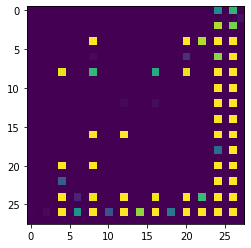

In [14]:
from matplotlib import pyplot as plt
latent_vars = tf.random.normal(shape=(batch_size, latent_dim))
generated_images = gan.generator.predict(latent_vars)

plt.imshow(generated_images[0])

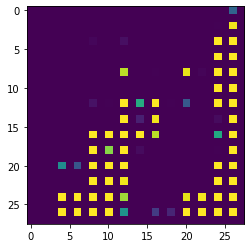

In [15]:
plt.imshow(generated_images[1])

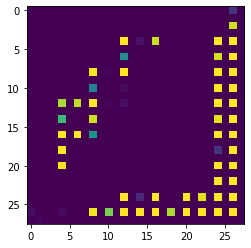

In [16]:
plt.imshow(generated_images[3])

In [36]:
latent_vars[0].numpy()

array([-1.5802194 , -0.499148  ,  0.30633062, -0.11604961,  0.07427307,
       -0.04345041, -0.48596954, -1.4642214 ,  0.7149696 ,  0.05236728,
        0.32803646, -0.07477933,  0.22999904, -1.7133629 ,  1.0245575 ,
        0.6277333 ,  1.7644238 ,  0.0881021 ,  1.2164513 , -0.2291243 ,
       -2.873728  , -1.7195424 ,  0.2562579 , -1.0050159 , -1.5120717 ,
        0.16018914,  1.6410034 ,  1.4033306 ,  3.4686618 ,  0.55517584,
        0.35113937,  1.0454962 ,  1.3089386 ,  0.3627758 , -0.51764506,
       -0.8305037 ,  1.3678116 , -0.1329903 ,  0.21478285,  2.1494622 ,
        0.47667626,  0.05986632,  0.70303017, -1.0749612 ,  0.93774074,
        0.8634863 ,  1.4615948 , -0.51960063,  0.56304747,  0.05936155,
        0.99722785,  0.39487058,  0.9602397 , -0.79876864, -0.36694285,
       -0.8704237 ,  1.6571267 , -1.0553519 ,  0.34429288, -0.34191522,
       -0.70940536,  1.1061265 ,  1.8519434 , -0.8858478 ,  1.8746613 ,
       -0.8729174 , -0.48558542,  1.6991197 , -0.19379544, -0.78

In [20]:
from matplotlib import pyplot as plt
plt.plot(history['d_loss'])
plt.plot(history['g_loss'])

NameError: name 'history' is not defined

[PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

Epoch 1/20
1094/1094 [==============================] - 29s 26ms/step - d_loss: 0.3872 - g_loss: 2.0883

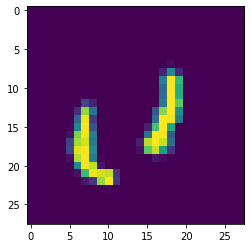

In [17]:
history = gan.fit(dataset, epochs=20)
latent_vars = tf.random.normal(shape=(batch_size, latent_dim))
generated_images = gan.generator.predict(latent_vars)
plt.imshow(generated_images[0])

In [ ]:
plt.imshow(generated_images[1])

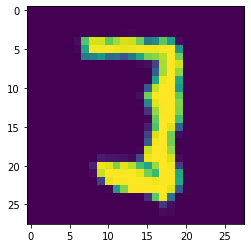

In [19]:
plt.imshow(generated_images[2])

